In [1]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetsClassData

config = Configs('epic_hybrid.yaml') 
jets = JetsClassData(config.data, standardize=False)

INFO: created experiment instance gauss_to_tops_ConditionalMarkovBridge_HybridEPiC_2024.09.30_19h12_3030


## JetClass data

In [2]:
(jets.target.continuous.shape, 
jets.source.continuous.shape, 
jets.target.discrete.shape,
jets.source.discrete.shape,  
jets.target.mask.shape,
jets.source.mask.shape)

(torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]))

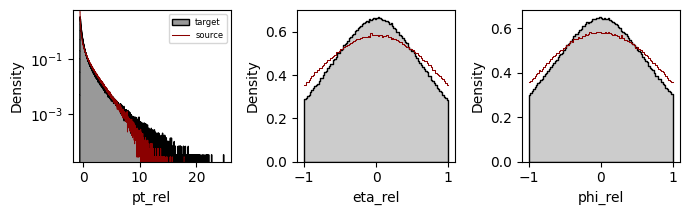

In [3]:
mask_target = (jets.target.mask > 0).squeeze() 
mask_source = (jets.source.mask > 0).squeeze() 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt_rel', mask=mask_target, ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', mask=mask_source, ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.2, label='target')
jets.source.histplot('eta_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.2, label='target')
jets.source.histplot('phi_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(None, None)

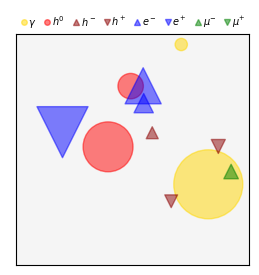

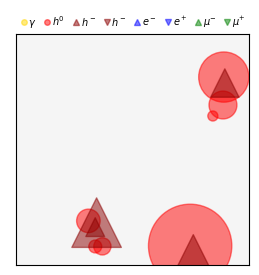

In [4]:
jets.source.display_cloud(idx=10,  scale_marker=200.0), jets.target.display_cloud(idx=10,  scale_marker=200.0)


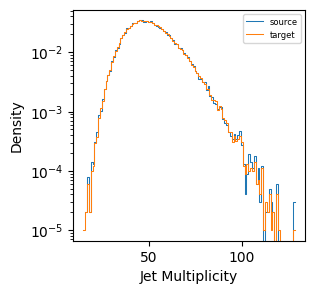

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CMB

In [2]:
from cmb.models.trainers import GenerativeDynamicsModule
epic_cmb = GenerativeDynamicsModule(config, jets)
epic_cmb.train()


2024-09-30 19:12:30.127426: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 19:12:30.165049: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 19:12:30.165733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 19:12:30.971655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver


INFO: number of training parameters: 881142
INFO: start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 90000, validation size: 10000, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'dim'

# Inference

### load trained model

In [2]:
from cmb.models.trainers import GenerativeDynamicsModule

path='/home/df630/CMB/results/JetClass/beta-gauss_to_tops_ConditionalMarkovBridge_HybridEPiC_2024.09.30_15h17_3528/config.yaml'
epic_cmb = GenerativeDynamicsModule(config=path)
epic_cmb.load(checkpoint='last')


2024-09-30 19:02:25.236502: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 19:02:25.274841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 19:02:25.275316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 19:02:26.060560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver
INFO: loading `last` epoch checkpoint from:
  - /home/df630/CMB/results/JetClass/beta-gauss_to_tops_ConditionalMarkovBridge_HybridEPiC_2024.09.30_15h17_3528/last_epoch.ckpt


### Generate data

In [9]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cmb.datasets.jetclass import JetsClassData
from cmb.datasets.jetclass import ParticleClouds

epic_cmb.config.data.source.test.num_jets = 10000
test = JetsClassData(epic_cmb.config.data, test=True, standardize=True)

epic_cmb.generate(source_continuous=test.source.continuous, 
                  source_discrete=test.source.discrete,
                  mask=test.source.mask,
                  output_history=False
                  )

INFO: generating samples...


In [10]:
sample = ParticleClouds(epic_cmb.sample, min_num_particles=0, max_num_particles=128, discrete_features=True) 

## Plot results

In [11]:
log = True
args_sam = {'stat':'density', 'log_scale':(False, log), 'fill':False, 'color':'darkred', 'lw':0.75, 'label':'generated (t=1)'}
args_tar = {'stat':'density', 'log_scale':(False, log), 'fill':True, 'color':'k','lw':0.3, 'alpha':0.2, 'label':'JetClass'}
args_src = {'stat':'density', 'log_scale':(False, log), 'fill':False, 'color':'darkblue','lw':0.75, 'label':'source (t=0)'}

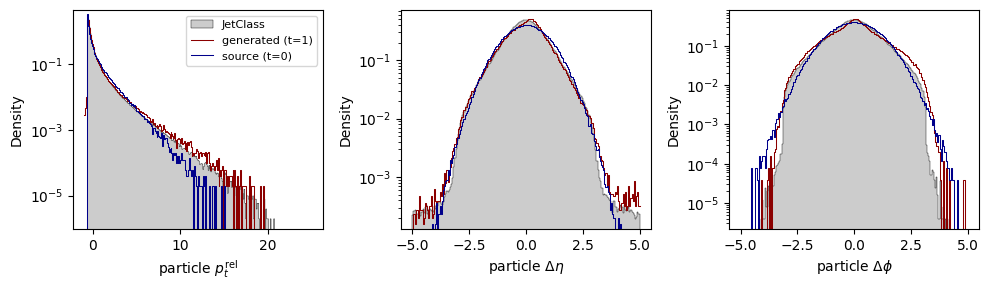

In [21]:
mask_target = (test.target.mask > 0).squeeze() 
mask_source= (test.source.mask > 0).squeeze() 
mask_sample = (sample.mask > 0).squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10,3))

test.target.histplot('pt_rel', mask=mask_target,  binrange=(-1, 25), binwidth=0.1, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_tar)
sample.histplot('pt_rel', mask=mask_sample, binrange=(-1, 25), binwidth=0.1, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0], **args_sam)
test.source.histplot('pt_rel', mask=mask_source,  binrange=(-1, 25), binwidth=0.1, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_src)

test.target.histplot('eta_rel', mask=mask_target,  binrange=(-5, 5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_tar)
sample.histplot('eta_rel', mask=mask_sample, binrange=(-5, 5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1], **args_sam)
test.source.histplot('eta_rel', mask=mask_source, binrange=(-5, 5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_src)

test.target.histplot('phi_rel', mask=mask_target,  binrange=(-5, 5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_tar)
sample.histplot('phi_rel', mask=mask_sample, binrange=(-5, 5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2], **args_sam)
test.source.histplot('phi_rel', mask=mask_source, binrange=(-5, 5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_src)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_distributions.png')
plt.show()

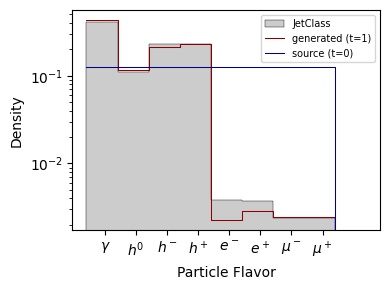

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
                                  
sns.histplot(test.target.discrete[mask_target].squeeze(), binrange=(-0.1, 7.1), element='step', discrete=True, **args_tar)
sns.histplot(sample.discrete[mask_sample].squeeze(), binrange=(-0.1, 7.1), element='step', discrete=True, **args_sam)
sns.histplot(test.source.discrete[mask_source].squeeze(), binrange=(-0.1, 7.1), element='step', discrete=True, **args_src)

ax.legend(loc='upper right', fontsize=7)
ax.set_xlabel('Particle Flavor')
ax.set_xticks(np.arange(8))
ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fraction.png')
plt.show()


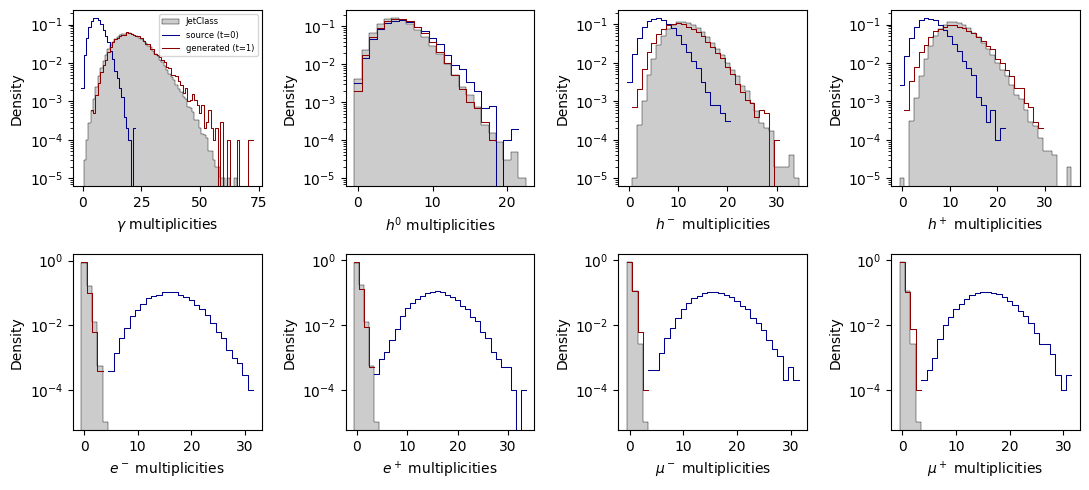

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(11, 5))

dic = {0: r'$\gamma$', 1: r'$h^0$', 2: r'$h^-$', 3: r'$h^+$', 4: r'$e^-$', 5: r'$e^+$', 6: r'$\mu^-$', 7: r'$\mu^+$'}

# First row of plots
for n in [0, 1, 2, 3]:
    sample_counts = (sample.discrete == n) * mask_sample.unsqueeze(-1)
    sample_counts = sample_counts.sum(dim=1)

    target_counts = (test.target.discrete == n) * mask_target.unsqueeze(-1)
    target_counts = target_counts.sum(dim=1)

    source_counts = (test.source.discrete == n) * mask_source.unsqueeze(-1)
    source_counts = source_counts.sum(dim=1)

    sns.histplot(target_counts.squeeze(), discrete=True, ax=ax[0, n], element='step', **args_tar)  # black for target
    sns.histplot(source_counts.squeeze(), discrete=True, ax=ax[0, n], element='step', **args_src)  # darkblue for source
    sns.histplot(sample_counts.squeeze(), discrete=True, ax=ax[0, n], element='step', **args_sam)  # darkred for sample

    ax[0, n].set_xlabel(f'{dic[n]} multiplicities')

# Second row of plots
for n in [0, 1, 2, 3]:
    sample_counts = (sample.discrete == 4 + n).sum(dim=1)
    target_counts = (test.target.discrete == 4 + n).sum(dim=1)
    source_counts = (test.source.discrete == 4 + n).sum(dim=1)

    sns.histplot(target_counts.squeeze(), discrete=True, ax=ax[1, n], element='step', **args_tar)  # black for target
    sns.histplot(source_counts.squeeze(), discrete=True, ax=ax[1, n], element='step', **args_src)  # darkblue for source
    sns.histplot(sample_counts.squeeze(), discrete=True, ax=ax[1, n], element='step', **args_sam)  # darkred for sample

    ax[1, n].set_xlabel(f'{dic[4 + n]} multiplicities')

ax[0, 0].legend(loc='upper right', fontsize=6)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_multiplicities.png')
plt.show()


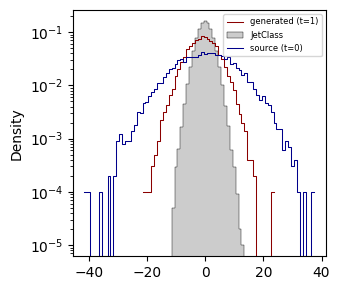

In [15]:
sample_total_charge = (sample.discrete == 2).sum(dim=1) - (sample.discrete == 3).sum(dim=1) + (sample.discrete == 4).sum(dim=1) - (sample.discrete == 5).sum(dim=1) + (sample.discrete == 6).sum(dim=1) - (sample.discrete == 7).sum(dim=1)
target_total_charge = (test.target.discrete == 2).sum(dim=1) - (test.target.discrete == 3).sum(dim=1) + (test.target.discrete == 4).sum(dim=1) - (test.target.discrete == 5).sum(dim=1) + (test.target.discrete == 6).sum(dim=1) - (test.target.discrete == 7).sum(dim=1)
source_total_charge = (test.source.discrete == 2).sum(dim=1) - (test.source.discrete == 3).sum(dim=1) + (test.source.discrete == 4).sum(dim=1) - (test.source.discrete == 5).sum(dim=1) + (test.source.discrete == 6).sum(dim=1) - (test.source.discrete == 7).sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(sample_total_charge.squeeze(), discrete=True, element='step', **args_sam)
sns.histplot(target_total_charge.squeeze(), discrete=True, element='step', **args_tar)
sns.histplot(source_total_charge.squeeze(), discrete=True, element='step', **args_src)
ax.legend(loc='upper right', fontsize=6)

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'jet_pt.png')
plt.show()


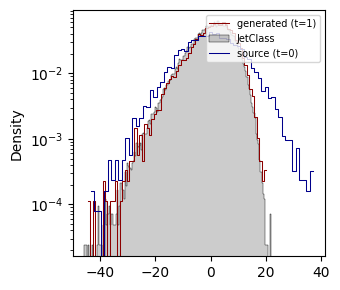

In [17]:
sample_jet_pt = sample.continuous[...,0].sum(dim=1)
target_jet_pt = test.target.continuous[...,0].sum(dim=1)
source_jet_pt = test.source.continuous[...,0].sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(sample_jet_pt,  element='step', **args_sam)
sns.histplot(target_jet_pt, element='step', **args_tar)
sns.histplot(source_jet_pt, element='step', **args_src)
ax.legend(loc='upper right', fontsize=7)

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'jet_pt.png')
plt.show()